# Classification of K-Forrelation Dataset using Structural Kernel

**Goals**: Attempt structural encoding as an algorithm for constructing quantum kernel capable of deciding the k-forrelation problem in the limit of small training dataset under binary encoding

In [1]:
#General Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import pylab as pl
import random

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.decomposition import PCA

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.extensions import UnitaryGate

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [2]:
# Constant
SEED = 2508
np.random.seed(SEED)

In [44]:
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

In [54]:
def execute_qasm(quantum_circuit, shots=8096):
    cir_meas = quantum_circuit.measure_all(inplace=False)
    qinst = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=shots)
    result = qinst.execute(cir_meas).get_counts()
    display(plot_histogram(result))

## 1. Load the Dataset from Matlab

In [4]:
datafile = loadmat('n3_k7_data.mat')
datafile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'NEG_dataset', 'POS_dataset', 'None', 'seed', 'test', 'train', 'validation', '__function_workspace__'])

In [5]:
df_train = pd.DataFrame(datafile['train'])
df_val = pd.DataFrame(datafile['validation'])
df_test = pd.DataFrame(datafile['test'])

X_train = df_train.iloc[:,0:-1].to_numpy()
y_train = df_train.iloc[:,-1].to_numpy()
X_val = df_val.iloc[:,0:-1].to_numpy()
y_val = df_val.iloc[:,-1].to_numpy()
X_test = df_test.iloc[:,0:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [6]:
# Reduce the dimension of the dataset
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [7]:
# Shrink the size of training dataset for the quantum circuit
n_examples = 100 # for both class combined
# Randomly samples the training set for both classes
random.seed(SEED)
rand_pos_ind = random.sample(range(0, 5000), int(n_examples/2))
rand_neg_ind = random.sample(range(5000, 10000), int(n_examples/2))
X_train_small = np.concatenate((X_train[rand_pos_ind],X_train[rand_neg_ind]))
X_train_pca_small = np.concatenate((X_train_pca[rand_pos_ind],X_train_pca[rand_neg_ind]))
y_train_small = np.concatenate((y_train[rand_pos_ind],y_train[rand_neg_ind]))

In [108]:
def plot_Gram(gram_mat):
    plt.imshow(gram_mat,interpolation='nearest', origin='upper', cmap='Blues')

## 2. Define blueprints and custom feature map for kernel learner

### 2.1. Universial gates blueprint

In [9]:
# TODO: generalize CNOT to pair any pair of qubits (increase number of basis gates, there will be multiple entries for CNOT)
# TODO: also return a dictionary from gate_ind --> gate (e.g., 2 --> CNOT(0,1))
def generate_sequences(length_bitstring, n_qubits, n_layers):
    """
    Args:
        length_bitstring [int]: length of input bit strings of the binary functions
        n_qubits [int]: number of qubits in the circuit
        n_layers [int]: number of length_bitstring-gate layers
            e.g., length_bitstring = 3; n_layers = 2 ==> each block has 3 * 2 = 6 basis gates
    Returns:
        sequence_list [list(list(int))] : list of generated sequence according to universial CNOT, H, T gates convention
    """
    sequence_list = []

    for i in range(length_bitstring):
        # randomly sample a sequence made from the set {0,1,..,n_qubits}
        sequence = np.random.choice(n_qubits+1,size=n_qubits*n_layers).tolist()

        # check if the sequence is already in the list of sequence, if so, sample again
        # TODO: this while loop can be expensive, method can be optimized
        while sequence in sequence_list:
            sequence = np.random.choice(n_qubits+1,size=n_qubits*n_layers).tolist()
        sequence_list.append(sequence)
    return sequence_list

In [13]:
test_sequence = generate_sequences(length_bitstring=3,n_qubits=3,n_layers=2)
test_sequence.sort()
print(test_sequence)

[[3, 0, 1, 0, 2, 3], [3, 3, 0, 2, 2, 1], [3, 3, 2, 3, 1, 2]]


In [14]:
# Define function to generate basis blocks for encoder circuit
# TODO: generalize function for more than 2 qubits (for the CNOT part)
def generate_unitaries(length_bitstring, n_qubits, n_layers):
    """
    Args:
        length_bitstring [int]: length of input bit strings of the binary functions
        n_qubits [int]: number of qubits in the circuit
        n_layers [int]: number of length_bitstring-gate layers
            e.g., length_bitstring = 3; n_layers = 2 ==> each block has 3 * 2 = 6 basis gates

    Returns:
        unitaries_list [list(QuantumCircuit)]: list of `n` unitaries to encode boolean functions
    """
    unitaries_list = []
    sequence_list = generate_sequences(length_bitstring, n_qubits, n_layers)
    qubit_index_list = np.arange(n_qubits)
    # each sequence has length n_qubits * n_layers
    for sequence in sequence_list:
        qc = QuantumCircuit(n_qubits)
        for i in range(len(sequence)):
            gate_code = sequence[i]
            qubit_to_apply = i % n_qubits

            # below is hardcode for n = 3, n_qubits = 2, to be changed later
            if gate_code == 0: qc.h(qubit_to_apply)
            elif gate_code == 1: qc.t(qubit_to_apply)
            else:
                cx_target_list = np.delete(qubit_index_list,qubit_to_apply)
                qc.cx(qubit_to_apply,cx_target_list[gate_code-2])
        unitaries_list.append(qc)

    return unitaries_list, sequence_list

In [63]:
test_unitary_list, test_sequences = generate_unitaries(length_bitstring=3,n_qubits=4,n_layers=1)
print(test_unitary_list)
test_sequences

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D5CFD0EC70>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D5CFD0E2B0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D5CFE9F6D0>]


[[3, 4, 4, 4], [3, 3, 1, 3], [4, 1, 1, 2]]

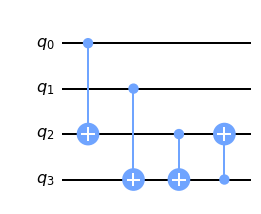

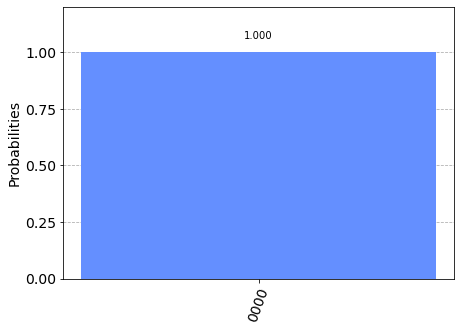

In [64]:
display(test_unitary_list[0].draw('mpl'))
execute_qasm(test_unitary_list[0])

In [58]:
# Define a function to encode a boolean function into a unitary
def unitary_from_func(unitaries_list,func_vec):
    """
    Args:
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences
        func_vec [np.array]: a vector that encodes a boolean function
    Returns:
        func_encoder [QuantumCircuit]: Unitary that encodes the given function
    """
    n_qubit = unitaries_list[0].width()
    func_encoder = QuantumCircuit(n_qubit)
    sig_bit_indices = np.nonzero(func_vec)[0].astype(int)
    for sig_bit_index in sig_bit_indices:
        func_encoder.compose(unitaries_list[sig_bit_index],qubits=range(n_qubit),inplace=True)

    return func_encoder

In [85]:
# Define a function to generate the encoder circuit for an instance of k-forrelation (one example)
def generate_encoder(unitaries_list, kf_instance, n, inverse=False):
    """
    Args:
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences
        kf_instance [np.array]: a k-forrelation instance
        n [int] : length of input bit string in the example
        inverse [boolean] : to generate the inverse encoder

    Returns:
        encoder [QuantumCircuit]: encoder for the input instance
    """
    n_qubit = unitaries_list[0].width()
    func_vec_list = np.array_split(kf_instance,len(kf_instance)/n)
    encoder = QuantumCircuit(n_qubit)
    # TODO: implement different choices of separation (H, barrier, entanglement, etc.)
    encoder.h(range(n_qubit))

    for func_vec in func_vec_list:
        encoder.compose(unitary_from_func(unitaries_list,func_vec),qubits=range(n_qubit),inplace=True)
        encoder.h(range(n_qubit))
        encoder.barrier()

    return encoder if not inverse else encoder.inverse()

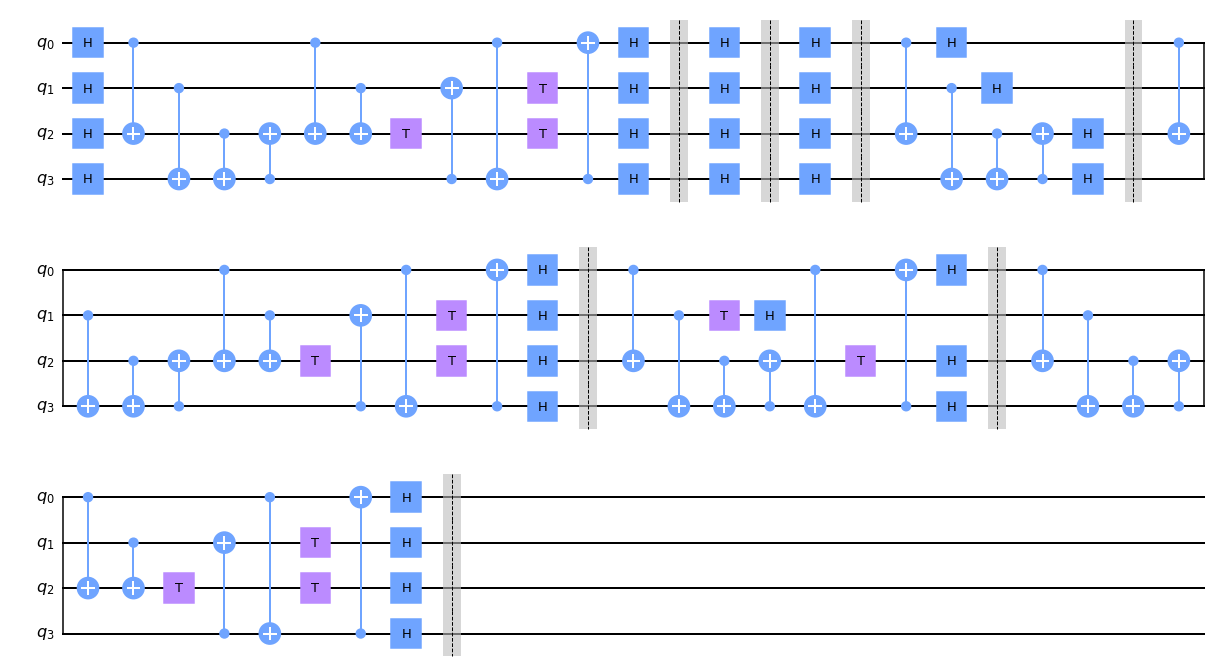

In [81]:
test_encoder = generate_encoder(test_unitary_list,X_train_small[0],3)
display(test_encoder.draw('mpl'))
# test_encoder_trans = generate_encoder(test_unitary_list,X_train_small[0],3,transpose=True)
# display(test_encoder_trans.draw('mpl'))
# test_qc = test_encoder.compose(test_encoder_trans)
# test_qc.draw('mpl')

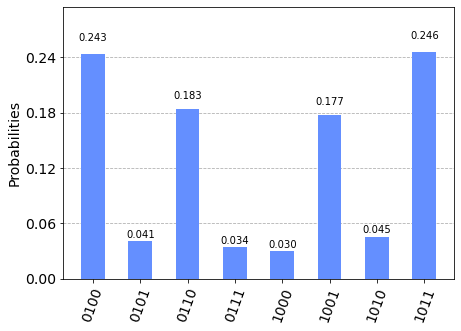

In [82]:
execute_qasm(test_encoder)

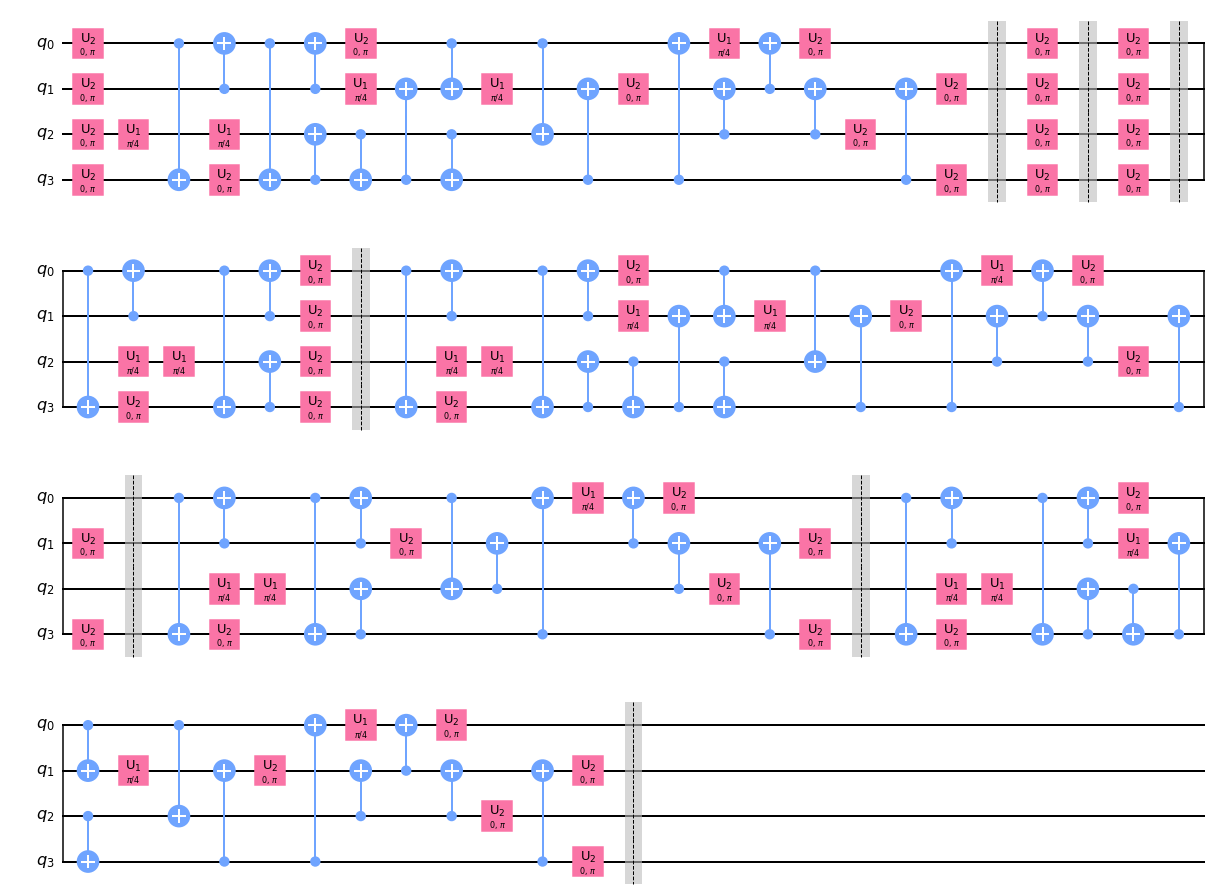

In [52]:
# visualize transpiled (optimized) circuit
test_encoder_trs = transpile(test_encoder,optimization_level=3)
test_encoder_trs.decompose().draw('mpl')

In [92]:
def prepare_all_encoders(data_mat, length_bitstring, unitaries_list, inverse=False):
    """
    Args:
        data_mat [np.array]: data storage matrix of size (m_examples x dim)
        length_bitstring [int] : length of input bit string in the examples
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences

    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoders (one for each example in the dataset)
    """
    all_encoders = []
    all_encoders.extend([generate_encoder(unitaries_list,kf_instance,length_bitstring,inverse) for kf_instance in data_mat])
    return all_encoders

In [106]:
# Function to that takes in two example sets and return the kernel matrix (with parallelism)
length_bitstring = None
unitaries_list = None
quantum_instance = None # assuming statevector_simulator
# ^^ dummy variables to keep IDE from showing error (these will be defined within a wrapper function)

def universal_gates_kernel(X1,X2):
    """
    Args:
        X1 [np.array] : matrix of shape (n_samples_1, n_features)
        X2 [np.array] : matrix of shape (n_samples_2, n_features)
    Returns:
        K [np.array] : kernel matrix of shape (n_samples_1, n_samples_2)
    """

    N_1 = X1.shape[0]
    N_2 = X2.shape[0]
    K = np.zeros((N_1,N_2))

     # Create list of encoders and inverse encoders for X1 and X2, respectively
    encoders_X1 = prepare_all_encoders(X1,length_bitstring,unitaries_list)
    encoders_X2 = prepare_all_encoders(X2,length_bitstring,unitaries_list,inverse=True)

    # If X1 == X2 (during training), only calculate half of the kernel matrix
    if (N_1==N_2) and (X1==X2).all():
        for i in range(N_1):
            for j in range(i+1,N_2):
                qc = encoders_X1[i].compose(encoders_X2[j])
                k_val = np.absolute(quantum_instance.execute(qc).get_statevector()[0])**2
                K[i,j] = k_val
                K[j,i] = k_val
                # print(f'Done: {i} -- {j}')
            K[i,i] = 1.0
            print(f'Done row {i} / {N_1-1}')
    else:
        for i in range(N_1):
            for j in range(N_2):
                qc = encoders_X1[i].compose(encoders_X2[j])
                k_val = np.absolute(quantum_instance.execute(qc).get_statevector()[0])**2
                K[i,j] = k_val
            print(f'Done row {i} / {N_1-1}')

    return K

In [107]:
# Test kernel function
length_bitstring = 3
n_qubits = 4
n_layers = 1
unitaries_list, sequence_list = generate_unitaries(length_bitstring, n_qubits, n_layers)
quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
K = universal_gates_kernel(X_train_small,X_train_small)

Done row 0 / 99
Done row 1 / 99
Done row 2 / 99
Done row 3 / 99
Done row 4 / 99
Done row 5 / 99
Done row 6 / 99
Done row 7 / 99
Done row 8 / 99
Done row 9 / 99
Done row 10 / 99
Done row 11 / 99
Done row 12 / 99
Done row 13 / 99
Done row 14 / 99
Done row 15 / 99
Done row 16 / 99
Done row 17 / 99
Done row 18 / 99
Done row 19 / 99
Done row 20 / 99
Done row 21 / 99
Done row 22 / 99
Done row 23 / 99
Done row 24 / 99
Done row 25 / 99
Done row 26 / 99
Done row 27 / 99
Done row 28 / 99
Done row 29 / 99
Done row 30 / 99
Done row 31 / 99
Done row 32 / 99
Done row 33 / 99
Done row 34 / 99
Done row 35 / 99
Done row 36 / 99
Done row 37 / 99
Done row 38 / 99
Done row 39 / 99
Done row 40 / 99
Done row 41 / 99
Done row 42 / 99
Done row 43 / 99
Done row 44 / 99
Done row 45 / 99
Done row 46 / 99
Done row 47 / 99
Done row 48 / 99
Done row 49 / 99
Done row 50 / 99
Done row 51 / 99
Done row 52 / 99
Done row 53 / 99
Done row 54 / 99
Done row 55 / 99
Done row 56 / 99
Done row 57 / 99
Done row 58 / 99
Done ro

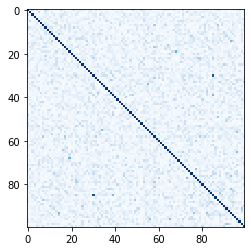

In [109]:
plot_Gram(K)

In [110]:
K

array([[1.00000000e+00, 1.79132283e-02, 2.13388348e-01, ...,
        1.27288228e-01, 3.25904131e-02, 6.88739374e-02],
       [1.79132283e-02, 1.00000000e+00, 6.70206544e-03, ...,
        4.72675979e-02, 1.33367717e-02, 8.87283832e-02],
       [2.13388348e-01, 6.70206544e-03, 1.00000000e+00, ...,
        6.66838586e-02, 1.37293696e-02, 4.73741673e-02],
       ...,
       [1.27288228e-01, 4.72675979e-02, 6.66838586e-02, ...,
        1.00000000e+00, 5.33470869e-02, 1.87559187e-02],
       [3.25904131e-02, 1.33367717e-02, 1.37293696e-02, ...,
        5.33470869e-02, 1.00000000e+00, 6.53664473e-32],
       [6.88739374e-02, 8.87283832e-02, 4.73741673e-02, ...,
        1.87559187e-02, 6.53664473e-32, 1.00000000e+00]])